# Model Training Notebook

In [34]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import spearmanr, kendalltau
from imblearn.over_sampling import SMOTENC

In [35]:
# load data
df = pd.read_csv('clean-data.csv')
df

,provinsi_id,kabupaten_id,kepadatan_penduduk,tingkat_pendidikan,tingkat_pengangguran,akses_air_bersih,akses_listrik,fasilitas_kesehatan,jalan_aspal,luas_sawah,pendapatan_perkapita,jenis_wilayah,kemiskinan
0,31,305,19.57,13.01,3.72,74.06,96.23,12,86.00,2101.76,2705981.87,urban,0
1,1,428,6.14,7.51,3.05,73.02,88.13,15,74.24,5859.39,2016187.82,rural,0
2,2,331,217.07,7.21,5.27,82.95,90.19,18,85.10,8691.70,675611.60,rural,0
3,17,31,47.50,9.36,5.58,89.56,90.01,17,79.57,1405.10,4099417.78,urban,0
4,9,288,57.10,2.64,10.15,92.60,66.53,18,86.26,7987.04,916190.12,urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9,87,72.50,3.99,13.23,87.15,83.03,22,53.32,1210.91,1396883.87,urban,1
4996,9,447,5770.99,9.53,6.12,91.68,90.88,10,69.20,4313.77,3128132.00,rural,0
4997,2,196,106.59,14.16,10.34,64.41,84.00,19,73.76,1116.63,13012722.68,urban,0
4998,4,437,35.64,7.11,5.51,96.32,91.54,12,77.03,258.13,5135349.80,urban,0


## A. Feature Engineering

### Data Types Casting

In [36]:
df['jenis_wilayah'] = df['jenis_wilayah'].astype(str)

### Handle Cardinality

In [37]:
list_car = []

# categorical columns
cat_cols = ['jenis_wilayah']

# iteration for the cardinality table
for col in cat_cols:
    list_car.append([col, df[col].nunique(), df[col].unique()])


pd.DataFrame(columns=['nama_kolom', 'jumlah_nilai_unik', 'nilai_unik'], data=list_car)

,nama_kolom,jumlah_nilai_unik,nilai_unik
0,jenis_wilayah,2,"[urban, rural]"


Explanation:

Cardinality in the columns is low. So we don't need to handle cardinality.

### Split Between Features and Target

In [38]:
# split data
X = df.drop(columns=['kemiskinan'])
y = df['kemiskinan']

In [39]:
# show target column
y

0       0
1       0
2       0
3       0
4       1
       ..
4995    1
4996    0
4997    0
4998    0
4999    0
Name: kemiskinan, Length: 5000, dtype: int64

### Split Between Train, Eval, and Test Set

In [40]:
# split data into train set and test set
X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, 
                                                              y, 
                                                              test_size=0.2, 
                                                              random_state=45)

# split train_eval data into train and eval
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval,
                                                    y_train_eval,
                                                    test_size=0.10,
                                                    random_state=45)

In [41]:
# shape of train and test set
print(f'Train set shape: {X_train.shape}')
print(f'Eval set shape: {X_eval.shape}')
print(f'Test set shape: {X_test.shape}')


Train set shape: (3600, 12)
Eval set shape: (400, 12)
Test set shape: (1000, 12)


Explanation:

Train set and test set divided with a ratio of 80:20, with train set percentage is 80 percent and test set is 20 percent.

### Handle Outliers

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   provinsi_id           5000 non-null   int64  
 1   kabupaten_id          5000 non-null   int64  
 2   kepadatan_penduduk    5000 non-null   float64
 3   tingkat_pendidikan    5000 non-null   float64
 4   tingkat_pengangguran  5000 non-null   float64
 5   akses_air_bersih      5000 non-null   float64
 6   akses_listrik         5000 non-null   float64
 7   fasilitas_kesehatan   5000 non-null   int64  
 8   jalan_aspal           5000 non-null   float64
 9   luas_sawah            5000 non-null   float64
 10  pendapatan_perkapita  5000 non-null   float64
 11  jenis_wilayah         5000 non-null   object 
 12  kemiskinan            5000 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 507.9+ KB


In [43]:
# numerical columns 
num_cols_outlier = ['kepadatan_penduduk',
       'tingkat_pendidikan', 'tingkat_pengangguran', 'akses_air_bersih',
       'akses_listrik', 'fasilitas_kesehatan', 'jalan_aspal', 'luas_sawah',
       'pendapatan_perkapita']

list_outlier = []

# iteration for checking if the column have normal or skew distribution
for col in num_cols_outlier:
    list_outlier.append([col, round(X_train[col].skew(),1), np.where(0.5 >= X_train[col].skew() >= -0.5,
                                                                      'normal', 'skew')])

# show the table
skewness = pd.DataFrame(columns=['nama_kolom', 'nilai_skewness', 'tipe_distribusi'], data=list_outlier)
skewness


,nama_kolom,nilai_skewness,tipe_distribusi
0,kepadatan_penduduk,13.5,skew
1,tingkat_pendidikan,-0.0,normal
2,tingkat_pengangguran,1.4,skew
3,akses_air_bersih,-0.8,skew
4,akses_listrik,-1.1,skew
5,fasilitas_kesehatan,0.3,normal
6,jalan_aspal,-0.2,normal
7,luas_sawah,2.0,skew
8,pendapatan_perkapita,3.2,skew


In [44]:
columns = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  column = skewness['nama_kolom'][row]
  # if is have skewed distributions
  if skewness['tipe_distribusi'][row] == 'skewed':
    IQR = X_train[column].quantile(0.75) - X_train[column].quantile(0.25)
    lower_boundary = X_train[column].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[column].quantile(0.75) + (IQR * 3)
  # if is have normal distribution
  else:
    lower_boundary = X_train[column].mean() - 3* X_train[column].std()
    upper_boundary = X_train[column].mean() + 3* X_train[column].std()
  # append to list
  columns.append(column)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[column] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[column] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

# create table 
outliers = pd.DataFrame({
    'kolom': columns,
    'batas_atas': [round(upper_bound,2) for upper_bound in upper_bound],
    'batas_bawah': [round(lower_bound,2) for lower_bound in lower_bound],
    'persentase_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,kolom,batas_atas,batas_bawah,persentase_outlier
0,kepadatan_penduduk,4272.25,-3365.98,1.44
1,tingkat_pendidikan,15.91,1.05,0.19
2,tingkat_pengangguran,18.38,-6.45,1.19
3,akses_air_bersih,117.59,37.92,0.67
4,akses_listrik,117.44,51.63,1.06
5,fasilitas_kesehatan,26.68,3.46,0.36
6,jalan_aspal,110.41,13.97,0.06
7,luas_sawah,19908.28,-9905.07,1.72
8,pendapatan_perkapita,10585554.34,-5064032.23,1.92


Explanation:

Percentage of outliers are below 5%, so we don't need to do a capping process.

### Handle Missing Values

In [45]:
# check missing value
df.isna().sum().sum()

0

Explanation:

No missing value in the data

### Feature Selection

In [46]:
# check target skweness value
y.skew()

1.589202992805475

Explanation:

Target distribution type is skewed

In [47]:
# drop provinsi_id and kabupaten_id becasue we don't need to include it in training process because is
# a unique value representing for each region
X_train = X_train.drop(columns=['provinsi_id', 'kabupaten_id'])
X_test = X_test.drop(columns=['provinsi_id', 'kabupaten_id'])

In [48]:
# checking feature importances for numerical columns

# list of numerical columns
num_cols = ['kepadatan_penduduk',
       'tingkat_pendidikan', 'tingkat_pengangguran', 'akses_air_bersih',
       'akses_listrik', 'fasilitas_kesehatan', 'jalan_aspal', 'luas_sawah',
       'pendapatan_perkapita']

feature_rf = RandomForestClassifier()
feature_rf.fit(X_train[num_cols], y_train)

# create dataframe for feature importances
num_selection = pd.DataFrame({
    'nama_kolom': num_cols,
    'kepentingan_fitur': feature_rf.feature_importances_
})

num_selection

,nama_kolom,kepentingan_fitur
0,kepadatan_penduduk,0.011455
1,tingkat_pendidikan,0.191564
2,tingkat_pengangguran,0.011372
3,akses_air_bersih,0.178254
4,akses_listrik,0.169176
5,fasilitas_kesehatan,0.006905
6,jalan_aspal,0.010346
7,luas_sawah,0.011020
8,pendapatan_perkapita,0.409908


### Data Balancing

In [49]:
# check balance of the data
unbalanced_data = y.value_counts().reset_index()

# calculate percentage
unbalanced_data['percentase'] = (unbalanced_data['count']/unbalanced_data['count'].sum()) * 100

# show table
unbalanced_data.round(2)

,kemiskinan,count,percentase
0,0,4055,81.1
1,1,945,18.9


Explanation:

The data have a moderate imbalanced data. We need to balance it using SMOTENC

In [50]:
X_train

,kepadatan_penduduk,tingkat_pendidikan,tingkat_pengangguran,akses_air_bersih,akses_listrik,fasilitas_kesehatan,jalan_aspal,luas_sawah,pendapatan_perkapita,jenis_wilayah
3315,445.53,9.35,6.20,80.99,96.26,11,61.86,490.02,1294872.18,rural
2214,23.46,8.53,2.67,54.18,94.21,20,36.59,5215.28,4786881.99,rural
2956,539.63,11.13,1.11,60.58,93.14,16,93.61,1551.84,5484818.08,urban
961,1007.42,7.64,4.32,55.00,88.91,8,75.73,3186.16,2203804.88,urban
3603,6377.07,13.07,12.32,57.76,79.10,16,80.56,6488.42,2578289.35,rural
...,...,...,...,...,...,...,...,...,...,...
4475,78.94,5.02,6.40,68.77,90.82,12,31.15,9732.30,1879400.25,urban
15,258.17,8.80,8.31,79.69,73.86,12,82.39,1899.40,1373596.69,urban
3955,352.47,9.90,11.23,81.54,67.38,17,66.21,12672.48,1431226.66,urban
2275,147.18,12.04,15.70,93.85,76.57,15,67.71,4587.65,1355670.39,rural


In [51]:
# balancing process
smotenc = SMOTENC([9], categorical_encoder=None, random_state=45)
X_train_resample, y_train_resample = smotenc.fit_resample(X_train, y_train)

c:\Users\Asus\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Asus\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [52]:
# check amount per target
balanced_data = y_train_resample.value_counts().reset_index()
balanced_data

,kemiskinan,count
0,0,2918
1,1,2918


Explanation:

The data now are balance.

### Create Pipeline for preprocessing process

In [53]:
skewness

,nama_kolom,nilai_skewness,tipe_distribusi
0,kepadatan_penduduk,13.5,skew
1,tingkat_pendidikan,-0.0,normal
2,tingkat_pengangguran,1.4,skew
3,akses_air_bersih,-0.8,skew
4,akses_listrik,-1.1,skew
5,fasilitas_kesehatan,0.3,normal
6,jalan_aspal,-0.2,normal
7,luas_sawah,2.0,skew
8,pendapatan_perkapita,3.2,skew


In [54]:
# list of column included in traiing process
num_cols = ['tingkat_pendidikan', 'akses_air_bersih','akses_listrik',
           'pendapatan_perkapita']
cat_cols = ['jenis_wilayah']

# create pipeline
num_pipeline = Pipeline([('scaler_standard', StandardScaler())])
cat_pipeline = Pipeline([('scaler_onehot', OneHotEncoder())])

# encoding pipeline
preprocess_pipe = ColumnTransformer([('num_pipe', num_pipeline, num_cols),
                                     ('cat_pipe', cat_pipeline, cat_cols)])

# encoding process
X_train_encoded = preprocess_pipe.fit_transform(X_train_resample)
X_eval_encoded = preprocess_pipe.transform(X_eval)
X_test_encoded = preprocess_pipe.transform(X_test)

# save pipeline
with open('encode_pipeline.pkl', 'wb') as encode:
    pickle.dump(preprocess_pipe, encode)

In [55]:
# target encoding
y_train_encoded = to_categorical(y_train_resample)
y_eval_encoded = to_categorical(y_eval)
y_test_encoded = to_categorical(y_test)

# show example encoded target
y_train_encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [56]:
X_train_resample

,kepadatan_penduduk,tingkat_pendidikan,tingkat_pengangguran,akses_air_bersih,akses_listrik,fasilitas_kesehatan,jalan_aspal,luas_sawah,pendapatan_perkapita,jenis_wilayah
0,445.530000,9.350000,6.200000,80.990000,96.260000,11,61.860000,490.020000,1.294872e+06,rural
1,23.460000,8.530000,2.670000,54.180000,94.210000,20,36.590000,5215.280000,4.786882e+06,rural
2,539.630000,11.130000,1.110000,60.580000,93.140000,16,93.610000,1551.840000,5.484818e+06,urban
3,1007.420000,7.640000,4.320000,55.000000,88.910000,8,75.730000,3186.160000,2.203805e+06,urban
4,6377.070000,13.070000,12.320000,57.760000,79.100000,16,80.560000,6488.420000,2.578289e+06,rural
...,...,...,...,...,...,...,...,...,...,...
5831,83.198153,7.199603,11.071017,55.571504,85.590285,15,80.007348,1701.405799,1.487657e+06,urban
5832,448.163139,7.197704,4.737232,83.861123,80.227841,12,64.487765,6418.104277,9.105912e+05,urban
5833,683.238992,5.798496,11.703052,73.055735,93.095052,13,80.004603,3849.547238,7.745619e+05,urban
5834,713.437946,7.321962,4.040112,52.960454,89.948333,13,64.753257,6551.156077,1.959667e+05,urban


## B. Model Training

In [57]:
X_train_encoded.shape[1]

6

In [58]:
# clear session
seed = 30
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# building model using sequential
model = Sequential()


model.add(Input(shape=X_train_encoded.shape[1], name='input_layer')) # input layer 
# we using three hidden layers with dense
model.add(Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
# adding regularisation with droput to improve generalisation
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model.add(Dense(2, activation='sigmoid')) # binary classification

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='model.keras',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [59]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3090 (12.07 KB)
Trainable params: 3090 (12

In [60]:
# learning model process
model_train = model.fit(X_train_encoded,
                        y_train_encoded,
                        epochs=20,
                        validation_data=(X_eval_encoded, y_eval_encoded),
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
166/183 [==========================>...] - ETA: 0s - loss: 0.5760 - accuracy: 0.7199
Epoch 1: saving model to model.keras
183/183 [==============================] - 2s 4ms/step - loss: 0.5663 - accuracy: 0.7298 - val_loss: 0.3906 - val_accuracy: 0.8575
Epoch 2/20
176/183 [===========================>..] - ETA: 0s - loss: 0.3804 - accuracy: 0.8485
Epoch 2: saving model to model.keras
183/183 [==============================] - 1s 3ms/step - loss: 0.3776 - accuracy: 0.8504 - val_loss: 0.2709 - val_accuracy: 0.8925
Epoch 3/20
180/183 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8710
Epoch 3: saving model to model.keras
183/183 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8715 - val_loss: 0.2407 - val_accuracy: 0.9025
Epoch 4/20
170/183 [==========================>...] - ETA: 0s - loss: 0.2872 - accuracy: 0.8853
Epoch 4: saving model to model.keras
183/183 [==============================] - 1s 3ms/step - loss: 0.2870 - acc

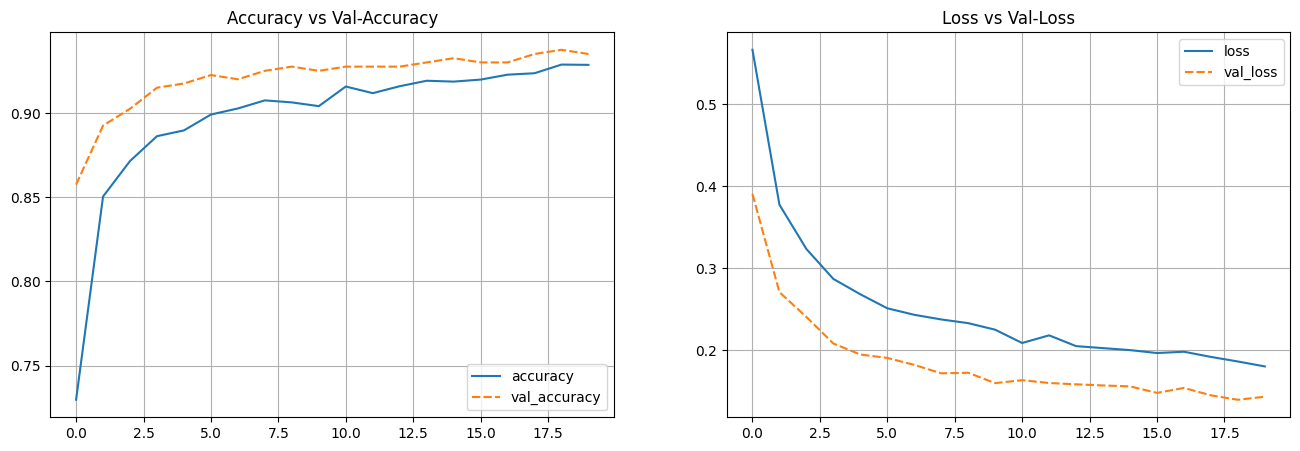

In [61]:
# plotting training results

model_train_hist = pd.DataFrame(model_train.history)

plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_train_hist[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_train_hist[['loss', 'val_loss']])
plt.ylim()
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [62]:
# load model that has been trained
model = load_model('model.keras')

In [63]:
# prediction process (in probability)
y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)

# conversion to label class
y_train_true = np.argmax(y_train_encoded, axis=1) if len(y_train_encoded.shape) > 1 and y_train_encoded.shape[1] > 1 else y_train_resample
y_test_true = np.argmax(y_test_encoded, axis=1) if len(y_test_encoded.shape) > 1 and y_test_encoded.shape[1] > 1 else y_test

32/32 [==============================] - 0s 1ms/step


In [64]:
# example results
y_train_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

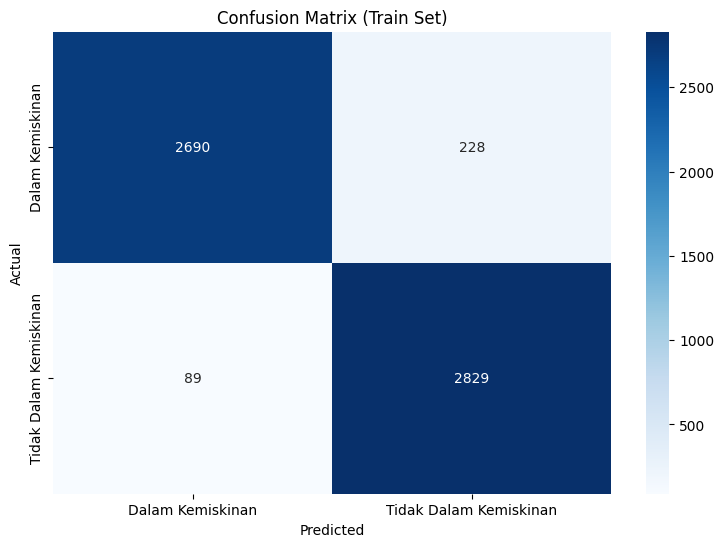

Classification Report (Train Set)
                        precision    recall  f1-score   support

      Dalam Kemiskinan       0.97      0.92      0.94      2918
Tidak Dalam Kemiskinan       0.93      0.97      0.95      2918

              accuracy                           0.95      5836
             macro avg       0.95      0.95      0.95      5836
          weighted avg       0.95      0.95      0.95      5836



In [65]:
# declaration confusion matrix train set
cm = confusion_matrix(y_train_true, y_train_pred)

# class name declaration
class_names = ['Dalam Kemiskinan', 'Tidak Dalam Kemiskinan']

# showing confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

# configuration for showing classification report
report = classification_report(y_train_true,
                               y_train_pred,
                               target_names=class_names,
                               zero_division=0)

# show classification report
print('Classification Report (Train Set)')
print(report)


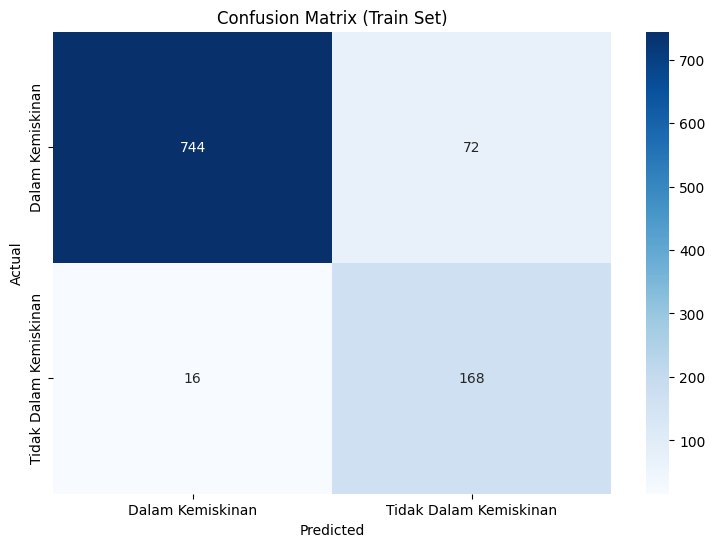

Classification Report (Test Set)
                        precision    recall  f1-score   support

      Dalam Kemiskinan       0.98      0.91      0.94       816
Tidak Dalam Kemiskinan       0.70      0.91      0.79       184

              accuracy                           0.91      1000
             macro avg       0.84      0.91      0.87      1000
          weighted avg       0.93      0.91      0.92      1000



In [66]:
# declaration confusion matrix train set
cm = confusion_matrix(y_test_true, y_test_pred)

# class name declaration
class_names = ['Dalam Kemiskinan', 'Tidak Dalam Kemiskinan']

# showing confusion matrix
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train Set)')
plt.show()

# configuration for showing classification report
report = classification_report(y_test_true,
                               y_test_pred,
                               target_names=class_names,
                               zero_division=0)

# show classification report
print('Classification Report (Test Set)')
print(report)

In [ ]:
# save model
model.save('fix-model.keras')